# PURPOSE

Demonstrate the use of `weibullutils` package that I made to help facilitate preparing failure data for weibull failure forecasting and to also help facilitate making plots.

In [1]:
from weibullutils import (
    add_median_ranks,
    weibull_params_linreg,
    weibull_cdf_table,
    weibull_mle_params,
    plot_weibull_cdf,
    plot_weibull_cdf_log_mrr,
    plot_weibull_cdf_mrr,
    plot_weibull_linreg,
)
import pandas as pd

### Obtain Sample Data

Using pandas library, we will read in sample failure data.  The failure mode that we're interested in forecasting is "Flair Failure".  Therefore, other failure modes should be considered as suspensions or suspended units.

In [2]:
df = pd.read_csv('../data/rivet_failures_with_status.csv')

In [3]:
df

,serial_number,failure_time_minutes,failure_mode,status
0,1,90,Flair Failure,failed
1,2,96,Flair Failure,failed
2,3,100,Flair loosened,suspended
3,4,30,Flair Failure,failed
4,5,49,Flair Failure,failed
5,6,45,Flair loosened,suspended
6,7,10,Lug failed,suspended
7,8,82,Flair Failure,failed


We have a total of 8 units.  5 of which had "Flair Failure" and 3 units failed with a different failure mode.  These 3 we would consider as "suspension" or "suspended" units.

### Calculate median rank for Weibull y-axis plotting positions

Next, we need to calculate Bernard's median ranks to help determine Weibull plotting positions for the y-axis.  `weibullutils` package comes with a handly `add_median_ranks` function which will create the median ranks for us.  The formula for median rank is below:

<center>$\huge{\texttt{median rank} = \frac{(rank - 0.3)}{(n + 0.4)}}$</center>

But, the equation above only applies if we have complete failure data - meaning that we waited until all units have failed and failed with the failure mode that we're interested in.  However, if we didn't wait for all of our units to fail or the unit failed with a failure mode that is not of interest to us, then in these cases, these units are referred to as "suspensions".  Then we have to first calculate what are known as adjusted ranks.  We then use adjusted ranks for the `rank` used in the equation above.  The formula below is what we would use to calculate the adjusted rank:

<center>$\huge{\texttt{Adjusted Rank} = \frac{(\texttt{Reverse Rank})(\texttt{Previous Adjusted Rank})+(N+1)}{(\texttt{Reverse Rank})+1}}$</center>

From the formula above, we see that we also need to have calcuated the reverse rank and keep track of the previous adjusted rank.  As previously mentioned, we would then use these adjusted ranks to calculate the median rank by replacing `rank` with `adjusted rank`:

<center>$\huge{\texttt{median rank when accounting for suspensions} = \frac{(\texttt{adjusted rank} - 0.3)}{(n + 0.4)}}$</center>

Steps to calculate the median rank when taking into account suspensions or suspended units:

1. Sort data by failure time
2. Create rank column
3. Create reverse rank column
4. Calculate adjusted rank as follows:
   - if the unit is a suspension or suspended, then it is not assigned a median rank
   - otherwise it is reverse rank times the previous adjusted rank (previous adjusted rank is zero for the first non-suspended unit) plus total # of units plus 1.  Then all of this divided by reverse rank plus 1:<br><br>
$\huge{\frac{(\texttt{Reverse Rank})(\texttt{Previous Adjusted Rank})+(N+1)}{(\texttt{Reverse Rank})+1}}$
5. Calculate median rank with the adjusted ranks calculated in step 4:<br><br>
$\huge{\frac{(\texttt{adjusted rank} - 0.3)}{(n + 0.4)}}$

Fortunately, the `add_median_ranks` function found in the `weibullutils` package also calculates the rank, reverse rank, and adjusted rank for us and adds them to our data set, along with the median rank:

In [4]:
add_median_ranks(data=df, col_failure_time='failure_time_minutes', col_status='status')

,serial_number,failure_time_minutes,failure_mode,status,rank,reverse_rank,adjusted_rank,median_rank
6,7,10,Lug failed,suspended,1,8,NaN,NaN
3,4,30,Flair Failure,failed,2,7,1.1250,0.098214
5,6,45,Flair loosened,suspended,3,6,NaN,NaN
4,5,49,Flair Failure,failed,4,5,2.4375,0.254464
7,8,82,Flair Failure,failed,5,4,3.7500,0.410714
0,1,90,Flair Failure,failed,6,3,5.0625,0.566964
1,2,96,Flair Failure,failed,7,2,6.3750,0.723214
2,3,100,Flair loosened,suspended,8,1,NaN,NaN


From above, we see that the `add_median_ranks()` function created the additional columns that we need.  So let's save our results into an actual variable:

In [5]:
df_final = add_median_ranks(data=df, col_failure_time='failure_time_minutes', col_status='status')

#### Let's look at our final data again

In [6]:
df_final

,serial_number,failure_time_minutes,failure_mode,status,rank,reverse_rank,adjusted_rank,median_rank
6,7,10,Lug failed,suspended,1,8,NaN,NaN
3,4,30,Flair Failure,failed,2,7,1.1250,0.098214
5,6,45,Flair loosened,suspended,3,6,NaN,NaN
4,5,49,Flair Failure,failed,4,5,2.4375,0.254464
7,8,82,Flair Failure,failed,5,4,3.7500,0.410714
0,1,90,Flair Failure,failed,6,3,5.0625,0.566964
1,2,96,Flair Failure,failed,7,2,6.3750,0.723214
2,3,100,Flair loosened,suspended,8,1,NaN,NaN


## Plot Failure Times and Apply Linear Regression

Now let's plot our failure times and apply linear regression to generate the best fit line to come up with the Weibull shape and scale parameters

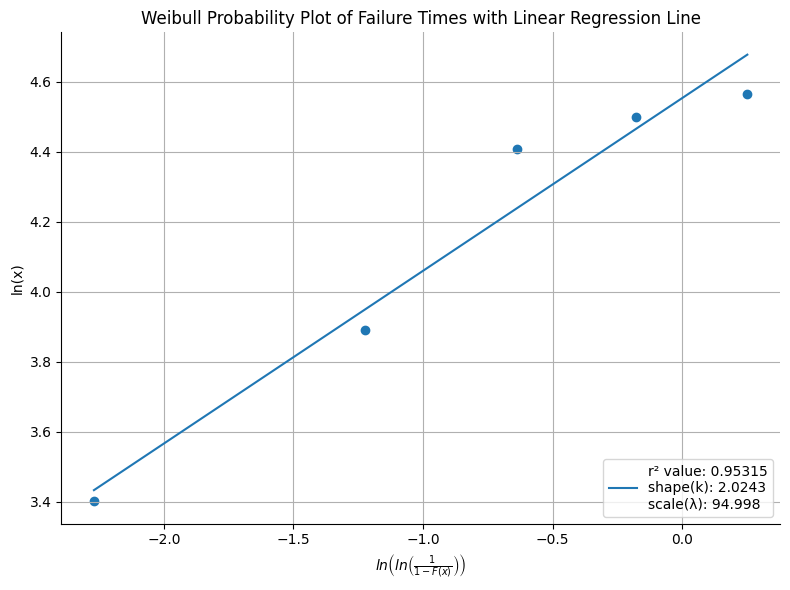

In [7]:
plot_weibull_linreg(data=df_final, col_failure_time='failure_time_minutes', col_median_rank='median_rank')

We see a plot has been generated and that the R squared value, shape, and scale parameters have also been calculated.

But we will use the `weibull_params_linreg()` function to obain those parameters and save them into a variable

In [8]:
weibull_params = weibull_params_linreg(data=df_final, col_failure_time='failure_time_minutes', col_median_rank='median_rank')

Let's see what we have as parameters

In [9]:
weibull_params

(0.9531480836566851, 2.0242585543715985, 94.99794288911302)

The first parameter is our R squared value, next is the shape parameter, then the scale parameter.

## Create Weibull Median Rank Regression (MRR) Probability Plot on Log Scale

Next, we'll use the `plot_weibull_cdf_log_mrr()` function to make our Weibull CDF plot on log scale using median rank regression (MRR)

In [10]:
shape = weibull_params[1]
scale = weibull_params[2]

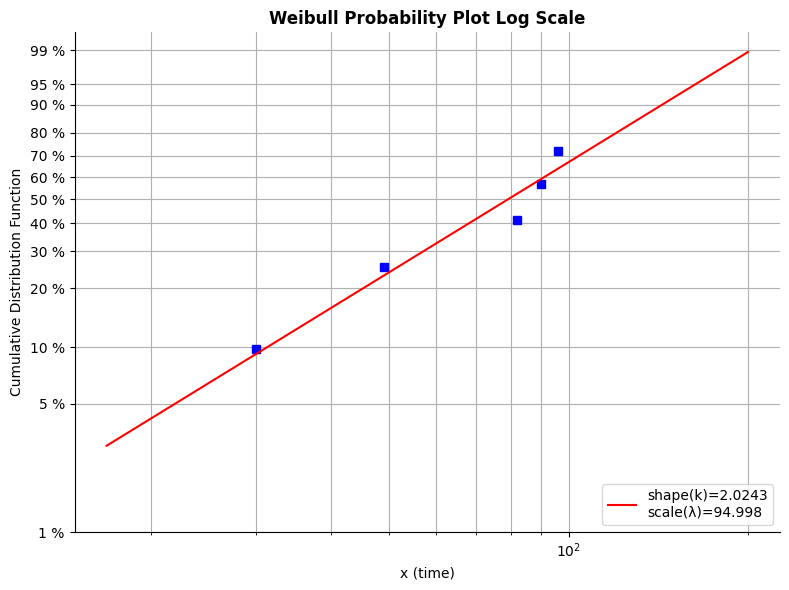

In [11]:
plot_weibull_cdf_log_mrr(
    data=df_final,
    col_failure_time='failure_time_minutes',
    col_median_rank='median_rank',
    shape=shape,
    scale=scale
)

#### We can also plot our Weibull CDF in non-log scale or normal, 1-to-1 scale using the `plot_weibull_cdf_mrr()` function

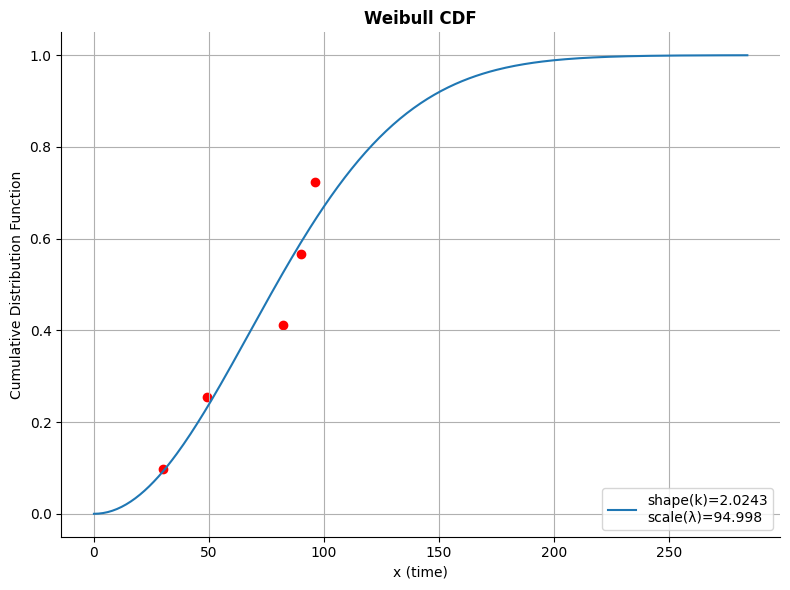

In [12]:
plot_weibull_cdf_mrr(
    data=df_final,
    col_failure_time='failure_time_minutes',
    col_median_rank='median_rank',
    shape=shape,
    scale=scale
)

But for making predictions, we need the actual raw values for the CDF.  This is where the `weibull_cdf_table()` comes in handy

In [13]:
weibull_cdf_predictions = weibull_cdf_table(shape=shape, scale=scale)

In [14]:
weibull_cdf_predictions.head()

,x,cdf
0,0.0,0.000000
1,1.0,0.000099
2,2.0,0.000404
3,3.0,0.000917
4,4.0,0.001640


In [15]:
weibull_cdf_predictions.tail()

,x,cdf
280,280.0,0.999866
281,281.0,0.999874
282,282.0,0.999882
283,283.0,0.999890
284,284.0,0.999897


#### So now, if someone were to ask me, what percentage of our units will have failed after 100 minutes, I can tell them with this table.

In [16]:
weibull_cdf_predictions.query("x==100")

,x,cdf
100,100.0,0.670264


#### The answer: 67% will have failed

## Obtaining Weibull MLE Estimates for Shape and Scale Parameters

The `weibullutils` package also has the `weibull_mle_params()` method to obtain MLE estimates for the Weibull shape and scale parameters.  All we have to do is pass in our data set containing the failure times and their status.

Below is our original data set:

In [17]:
df

,serial_number,failure_time_minutes,failure_mode,status
0,1,90,Flair Failure,failed
1,2,96,Flair Failure,failed
2,3,100,Flair loosened,suspended
3,4,30,Flair Failure,failed
4,5,49,Flair Failure,failed
5,6,45,Flair loosened,suspended
6,7,10,Lug failed,suspended
7,8,82,Flair Failure,failed


#### Now let's use the `weibull_mle_params()` method

In [18]:
weibull_mle_params(data=df, col_failure_time='failure_time_minutes', col_status='status')

(3.0170185648841996,
 87.9562918404288,
           k        k_diff
 0  2.399417           NaN
 1  2.893253  4.938356e-01
 2  3.011965  1.187120e-01
 3  3.017010  5.045217e-03
 4  3.017019  8.463143e-06
 5  3.017019  2.374545e-11
 6  3.017019 -5.773160e-15
 7  3.017019  0.000000e+00
 8  3.017019  0.000000e+00
 9  3.017019  0.000000e+00)

It returns 3 outputs:  The Weiubll shape MLE estimate, the Weibull scale MLE estimate, and the dataframe containing the shape values obtained using Newton-Raphson method where it eventually converged to our final k (shape) parameter.

In [19]:
shape_mle, scale_mle, df_mle = weibull_mle_params(data=df, col_failure_time='failure_time_minutes', col_status='status')

In [20]:
shape_mle

3.0170185648841996

In [21]:
scale_mle

87.9562918404288

In [22]:
df_mle

,k,k_diff
0,2.399417,NaN
1,2.893253,4.938356e-01
2,3.011965,1.187120e-01
3,3.017010,5.045217e-03
4,3.017019,8.463143e-06
5,3.017019,2.374545e-11
6,3.017019,-5.773160e-15
7,3.017019,0.000000e+00
8,3.017019,0.000000e+00
9,3.017019,0.000000e+00


#### Let's plot our CDF using the MLE parameters

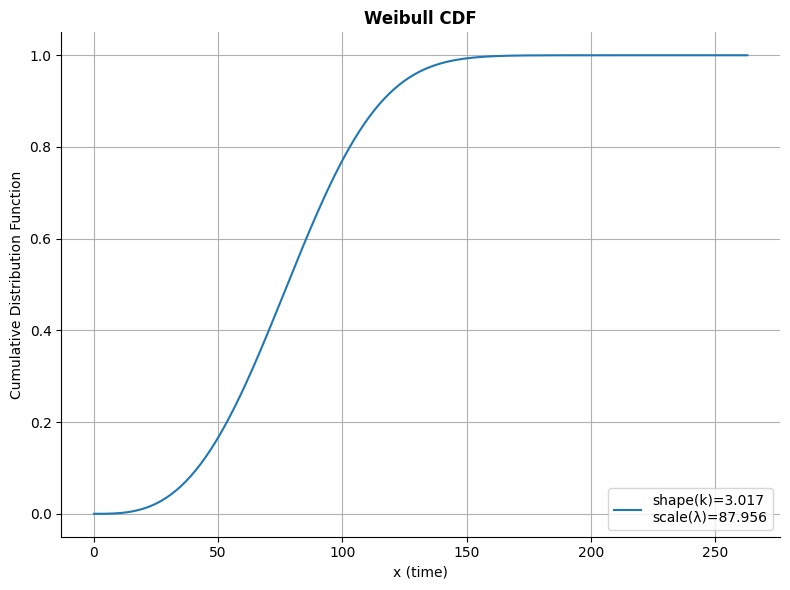

In [23]:
plot_weibull_cdf(shape=shape_mle, scale=scale_mle)

#### Let's obtain the failure prediction after 100 minutes

In [24]:
weibull_cdf_table(shape=shape_mle, scale=scale_mle).query("x==100")

,x,cdf
100,100.0,0.770721


According to our MLE estimates, 77% of our units will fail after 100 minutes.